# No-glue-code

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Cambdrige`


In [2]:
# The statistical inference frame-work we will use
using LogDensityProblems
using LogDensityProblemsAD
using DynamicPPL
using ForwardDiff
using Random
using LinearAlgebra

#Plotting
using PyPlot

#What we are tweaking
using Revise
using AdvancedHMC
using Turing

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling AdvancedHMC [0bf59076-c3b1-5ca4-86bd-e02cd72cde3d]
[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]


## Model

In [3]:
# Just a simple Neal Funnel
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DefaultContext()))

## Turing interface

In [5]:
struct Sampler
    metric
    integrator
    adaptor
    proposal
end

Sampler(ϵ::Number, TAP::Number) = begin
    metric =  DiagEuclideanMetric(d)
    integrator = Leapfrog(ϵ)
    proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(TAP, integrator))
    
    Sampler(
        metric,
        integrator,
        adaptor,
        proposal)
end

Sampler

In [6]:
initial_θ = randn(21)
initial_ϵ = 0.1 #find_good_stepsize(hamiltonian, initial_θ)
spl = Sampler(initial_ϵ, 0.95)

Sampler(DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]), Leapfrog(ϵ=0.1), StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.95, state.ϵ=0.1),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
), HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.1), tc=GeneralisedNoUTurn{Float64}(10, 1000.0))))

## Sampling

In [7]:
n_samples, n_adapts = 10_000, 1_000
samples, stats = sample(funnel_model, 0.1, 0.95, n_samples, n_adapts; initial_θ=initial_θ);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:00:04
  iterations:                                   10000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      31
  is_accept:                                    true
  acceptance_rate:                              0.9977556019563564
  log_density:                                  -55.59669800049129
  hamiltonian_energy:                           76.99245786344844
  hamiltonian_energy_error:                     -0.037907257288452456
  max_hamil

### Plotting

In [8]:
theta_mchmc = [sample[1] for sample in samples]
x10_mchmc = [sample[10+1] for sample in samples];

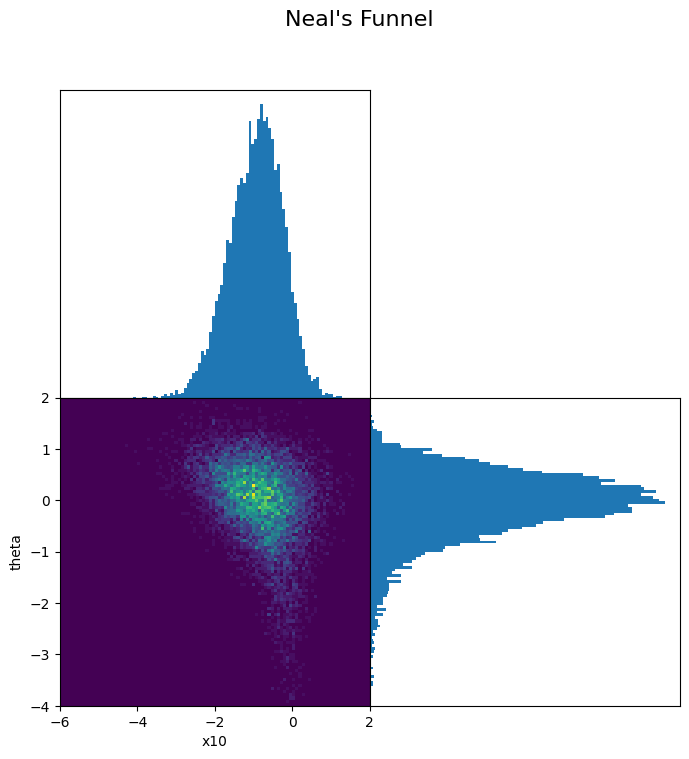

In [9]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## Sampling w AbstractMCMC

In [10]:
using MCMCChains

initial_ϵ=0.1 
TAP=0.95
nuts = AdvancedHMC.NUTSSampler(initial_ϵ, TAP, d)
Asamples = sample(funnel_model, nuts, 1000; chain_type=MCMCChains.Chains)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:00:03
  iterations:                                   1000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      31
  is_accept:                                    true
  acceptance_rate:                              0.9816437550853788
  log_density:                                  -56.98512987944265
  hamiltonian_energy:                           69.16094619031233
  hamiltonian_energy_error:                     0.0010654981857385337
  max_hamilt

Chains MCMC chain (1000×34×1 Array{Real, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64        Real    Float64   Float64    ⋯

           θ   -0.1701    0.8877    0.1015    107.2505    85.6230    1.0013    ⋯
          z1    0.5637    0.7028    0.0306    533.5203   657.9208    0.9992    ⋯
          z2    0.5754    0.7386    0.0267    795.9805   619.4501    0.9997    ⋯
          z3   -0.4002    0.6910    0.0189   1374.0798   542.6676    0.9993    ⋯
          z4    0.0920    0.7204    0.0168 

### Plotting

In [43]:
theta_mchmc = [sample[1] for sample in Asamples]
x10_mchmc = [sample[10+1] for sample in Asamples];

LoadError: MethodError: no method matching getindex(::AdvancedHMC.Transition{AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, NamedTuple{(:n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size, :is_adapt), Tuple{Int64, Bool, Float64, Float64, Float64, Float64, Float64, Int64, Bool, Float64, Float64, Bool}}}, ::Int64)

In [ ]:
Asamples[1].z.ℓκ

AdvancedHMC.DualValue{Float64, Vector{Float64}}(-30.568913420248535, [-1.5177868234276293, -0.2642441573758009, 2.9006618798256305, -0.49020897941818103, 0.3653601765991165, 2.6312133214525577, 0.10168289161602831, -1.6963705076408426, -2.00635197071912, -3.0012398194776444  …  3.7892210136171354, 0.9123812954243244, 1.4411600118405576, -1.1218982417030496, 0.567170185325859, 0.4590465066334209, 0.6414203316649082, 0.9499263148164698, 2.500361124794014, 0.6248394066847915])

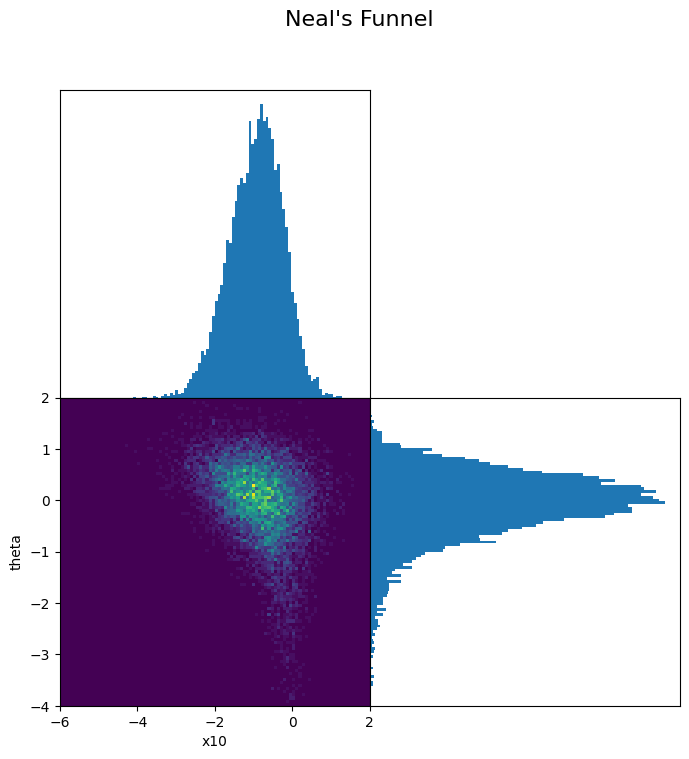

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## Sampling w Turing

In [ ]:
using Turing

In [ ]:
TAP = 0.95
nadapts = 300
spl = Turing.NUTS(nadapts, TAP)

In [ ]:
Turing.sample(funnel_model, spl, 50_000, progress=true; save_state=true)